# Name: Mohammad Javad Noroozi
# Student Number: 99102434
# HW3

In [1]:
import findspark
findspark.find()
findspark.init()

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("HW1") \
    .master("local[*]") \
    .getOrCreate()

sc=spark.sparkContext

24/02/02 03:41:14 WARN Utils: Your hostname, javad-IdeaPad-Gaming-3-15IAH7 resolves to a loopback address: 127.0.1.1; using 192.168.137.8 instead (on interface enp48s0)
24/02/02 03:41:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/02 03:41:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/02/02 03:41:15 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
tweets_rdd = sc.textFile("twitter_data_v2.jsonl")

In [3]:
tweets_rdd.takeSample(False, 1, 19)

['{"in_reply_to_status_id_str": null, "in_reply_to_user_id_str": null, "in_reply_to_status_id": null, "in_reply_to_user_id": null, "in_reply_to_screen_name": null, "truncated": false, "is_quote_status": false, "retweet_count": 3, "reply_count": 0, "quote_count": 0, "favorite_count": 0, "favorited": false, "retweeted": true, "possibly_sensitive": null, "lang": "fa", "geo": null, "view_count": 0, "tweet_type": "retweeted", "emojis": null, "text": "مردک وطن\u200cفروش بدبخت، ترانه آفتابکاران جنگل مال چی بوده که خوندن؟! موسیقی اصیل ایرانی بوده؟! یا سرود تروریست\u200cهای چریک کمونیست بوده؟!\\nاشکال نداره، شما به خزعبل گویی ادامه بدید. خوبیش اینه که مردم دارن کم کم متوجه میشن که شنا دگوری\u200cهای خائن وطن\u200cفروش چه جماعتی هستید.\\n\\n#ننگ_بر_سه_فاسد_ملا_چپی_مجاهد", "user": {"id": "315689091", "id_str": "315689091", "created_at": 1307868062, "name": "The Nerd", "screen_name": "NewbieBadASS", "location": "خیابون هفده شهریور ", "url": "https://t.co/ajpmxoYoTe", "description": "A supporter of

In [3]:
import json
import re
import math
import random
import datetime
import numpy as np
import matplotlib.pyplot as plt

In [5]:
tweets_rdd.count()

4175860

In [6]:
startt = datetime.datetime.now()
print(startt)

2024-01-30 16:09:36.523798


In [4]:
# Define Parameter
owner_s = 1

# following parameters should not be equal to owner_s
rep_to_s = 0.2
rep_from_s = 0.9

ret_to_s = 0.51
ret_from_s = 1.5

qut_to_s = 0.5
qut_from_s = 1.5


In [5]:
def to_user_tid_score(tid, uid, type, origin_tid, origin_uid):
    origin_tid = [i for i in origin_tid if i is not None]
    origin_uid = [i for i in origin_uid if i is not None]

    if not origin_tid or not origin_uid:
        return [(uid, [(tid, owner_s)])]

    to_s = rep_to_s if type == "replied" else\
           ret_to_s if type == "retweeted" else\
           qut_to_s if type == "quoted" else\
           0
    from_s = rep_from_s if type == "replied" else\
             ret_from_s if type == "retweeted" else\
             qut_from_s if type == "quoted" else\
             0

    return [(uid, [(tid, owner_s), (origin_tid[0], from_s)]),
            (origin_uid[0], [(tid, to_s)]),
           ]
    pass


def to_tid_user_score(tid, uid, type, origin_tid, origin_uid):
    origin_tid = [i for i in origin_tid if i is not None]
    origin_uid = [i for i in origin_uid if i is not None]

    if not origin_tid or not origin_uid:
        return [(tid, ((uid, owner_s),))]

    to_s = rep_to_s if type == "replied" else\
           ret_to_s if type == "retweeted" else\
           qut_to_s if type == "quoted" else\
           0
    from_s = rep_from_s if type == "replied" else\
             ret_from_s if type == "retweeted" else\
             qut_from_s if type == "quoted" else\
             0

    return [(tid, ((uid, owner_s), (origin_uid[0], to_s),)),
            (origin_tid[0], ((uid, from_s),)),
           ]
    pass


def extract_tuples(tweet_info, func):
    return func(
        tweet_info.get('id'),
        tweet_info["user"].get('id'),
        tweet_info.get('tweet_type'),
        [
            tweet_info.get('in_reply_to_status_id_str', None),
            tweet_info.get('quoted_status', {}).get('id'),
            tweet_info.get('retweeted_status', {}).get('id'),
        ],
        [
            tweet_info.get('in_reply_to_user_id_str', None),
            tweet_info.get('quoted_status', {}).get('user', {}).get('id'),
            tweet_info.get('retweeted_status', {}).get('user', {}).get('id'),
        ],
    )


def extract_relations(x):
    '''x: (tid, [(u, s), ...])'''
    threashold = 0.5
    tid, u_s = x
    relations = []
    
    for (u1, s1) in u_s:
        u1_relations = []
        for (u2, s2) in u_s:
            if u1 != u2 and s1 > threashold and s1 != owner_s:
                u1_relations.append((tid, u2, s1, s2))

        if len(u1_relations) > 10:
            relations.append((u1, sorted(u1_relations, key=lambda x: -x[2]*x[3])[:10]))
        else:
            relations.append((u1, u1_relations))
    return relations


def select_best(x):
    '''x: (u1, [(tid, u2, s1, s2),])'''
    u, relations = x
    if relations:
        th = rep_to_s
        while len(relations) > 25:
            new_relations = [r for r in relations if r[2]*r[3] > th]
            if len(new_relations) < 15:
                break
            relations = new_relations
            th *= 1.1

    return (u, relations)


def find_users_interest(x, user_scores):
    ''' 
        user_scores: {ui: [(t_j, s_ij), ...]}
        x: (u1, ((tid, uj, s1, sj), ...))
    '''
    th = 0.05
    u, relations = x
    interest = {}
    if relations:
        for (tid, uj, s1, s2) in relations:
            interest[tid] = interest.get(tid, 0) + s1
            for (t, s) in user_scores.get(uj, []):
                interest[t] = interest.get(t, 0) + s1*s2*s

    if interest:
        max_interest = max(interest.values())
        th = 0.05 * max_interest
        while len(interest) > 100:
            interest = {t:i for t,i in interest.items() if i > th}
            th *= 1.1
        return (u, interest)
    return (u,{})


In [6]:
# [((ui, ((t_j, s_ij),)) ...]
user_tid_score_rdd = tweets_rdd.flatMap(lambda x: extract_tuples(json.loads(x), func=to_user_tid_score))

# [(ui, ((t_j, s_ij), ...)), ...]
user_tids_scores_rdd = user_tid_score_rdd.reduceByKey(lambda x, y: x if not x.extend(y) else x)

user_scores_list = user_tids_scores_rdd.collect()

user_scores_dict = dict(user_scores_list)

In [7]:
# [(tid, [(u, s)]), ...]
tid_user_score_rdd = tweets_rdd.flatMap(lambda x: extract_tuples(json.loads(x), func=to_tid_user_score))

# [(tid, [(u, s), ...]), ...]
tid_users_scores_rdd = tid_user_score_rdd.reduceByKey(lambda x, y: x + y)

# [(u1, [(tid, u2, s1, s2)])]
user_relation_rdd = tid_users_scores_rdd.flatMap(lambda x: extract_relations(x))

# [(u1, [(tid, u2, s1, s2), ...])]
user_relations_rdd = user_relation_rdd.reduceByKey(lambda x, y: x if not x.extend(y) else x)

# [(u1, [(tid, u2, s1, s2), ...])]
user_best_relations_rdd = user_relations_rdd.map(lambda x: select_best(x))

# [(u1, [(tid, interest), ...])]
user_interests_rdd = user_best_relations_rdd.map(lambda x: find_users_interest(x, user_scores_dict))

# selected_user_interests_rdd = user_interests_rdd.filter(lambda x: x[0] == '933731737686994946')

In [9]:
uid = list(user_scores_dict.keys())[1]
selected_user_interests = user_interests_rdd.filter(lambda x: x[0] == uid).take(1)

In [10]:
important_key = ['tweet_type', 'user', 'is_quote_status', 'retweeted',
                 'id', 'in_reply_to_status_id_str', 'in_reply_to_user_id_str',
                 'quoted_status', 'is_quote_status', 'retweeted_status', 'text']


In [11]:
interests_tweets = tweets_rdd.filter(lambda x: json.loads(x)['id'] in selected_user_interests[0][1].keys() or
                                               json.loads(x)['user']['id'] == uid)\
                             .map(lambda x: dict(filter(lambda y: y[0] in important_key, json.loads(x).items())))\
                             .collect()
interests_tweets2 = interests_tweets.copy()


In [12]:
def extract_user_origin_tweets(tweets, uid):
    origin_tweets = []
    for t in tweets:
        if t['tweet_type'] == 'generated':
            if t.get('user',{}).get('id','0') == uid:
                origin_tweets.append(t)
    for t in origin_tweets:
        tweets.remove(t)
    return origin_tweets, tweets


def extract_user_replied_tweets(tweets, uid):
    replied_tweets = []
    for t in tweets:
        if t['tweet_type'] == 'replied':
            if t.get('user',{}).get('id','0') == uid:
                replied_tweets.append(t)
    for t in replied_tweets:
        tweets.remove(t)
    return replied_tweets, tweets


def extract_user_quoted_tweets(tweets, uid):
    quoted_tweets = []
    for t in tweets:
        if t['tweet_type'] == 'quoted' and t['is_quote_status']:
            if t.get('user',{}).get('id','0') == uid:
                quoted_tweets.append(t)
    for t in quoted_tweets:
        tweets.remove(t)
    return quoted_tweets, tweets


def extract_user_retweeted_tweets(tweets, uid):
    retweeted_tweets = []
    for t in tweets:
        if t['tweet_type'] == 'quoted' and t['retweeted']:
            if t.get('user',{}).get('id','0') == uid:
                retweeted_tweets.append(t)
    for t in retweeted_tweets:
        tweets.remove(t)
    return retweeted_tweets, tweets


def extract_replied_to_user_tweets(tweets, uid):
    replied_tweets = []
    for t in tweets:
        if t['tweet_type'] == 'replied':
            if t.get('in_reply_to_user_id_str', '0') == uid:
                replied_tweets.append(t)
    for t in replied_tweets:
        tweets.remove(t)
    return replied_tweets, tweets


def extract_quoted_user_tweets(tweets, uid):
    quoted_tweets = []
    for t in tweets:
        if t['tweet_type'] == 'quoted' and t['is_quote_status']:
            if t.get('quoted_status', {}).get('user', {}).get('id', '0') == uid:
                quoted_tweets.append(t)
    for t in quoted_tweets:
        tweets.remove(t)
    return quoted_tweets, tweets


def extract_retweeted_user_tweets(tweets, uid):
    retweeted_tweets = []
    for t in tweets:
        if t['tweet_type'] == 'quoted' and t['retweeted']:
            if t.get('retweeted_status', {}).get('user', {}).get('id', '0') == uid:
                retweeted_tweets.append(t)
    for t in retweeted_tweets:
        tweets.remove(t)
    return retweeted_tweets, tweets


def extract_explore_tweets(tweets):
    return tweets

In [13]:
interests_tweets = interests_tweets2.copy()
user_origin_tweets, interests_tweets = extract_user_origin_tweets(interests_tweets, uid)
user_quoted_tweets, interests_tweets  = extract_user_quoted_tweets(interests_tweets, uid)
user_retweeted_tweets, interests_tweets  = extract_user_retweeted_tweets(interests_tweets, uid)
user_replied_tweets, interests_tweets  = extract_user_replied_tweets(interests_tweets, uid)
replied_to_user_tweets, interests_tweets  = extract_replied_to_user_tweets(interests_tweets, uid)
quoted_user_tweets, interests_tweets  = extract_quoted_user_tweets(interests_tweets, uid)
retweeted_user_tweets, interests_tweets  = extract_retweeted_user_tweets(interests_tweets, uid)
explore_tweets = extract_explore_tweets(interests_tweets)

In [14]:
ts = [t['text'].replace('\u200c', '').split('\n') for t in user_origin_tweets]
for t in ts:
    for line in t:
        print(line)
    print('-'*100)

ای مگس عرصه سیمرغ نه جولانگه توست
عرض خود میبری و زحمت ما میداری
تو به تقصیر خود افتادی از این در محروم
از که مینالی و فریاد چرا میداری

#رضا_عقده_ایی 
#حزب_کارتنی https://t.co/MpmdadysLc
----------------------------------------------------------------------------------------------------
نمایشگاه «آنچه باقی ماند»

 #فواد_مصطفی_سلطانی 
#اعدام_های_فرودگاه_سنندج https://t.co/MuI2dGVlfy
----------------------------------------------------------------------------------------------------
پدرام شهلایی شاعر و خواننده ترانه «وره مەیدان/بیا به میدان» در یک ویدیو اعلام کرد که آهنگ خود را برای انقلاب #ژینا سروده و ظاهرا افراد سلطنت طلب (ایرانیان کرد میهن پرست ) در حال سواستفاده از این آهنگ برای منافع حزبی خود هستند . 
#زن_زندگى_آزادى https://t.co/JjFUWDmlHg
----------------------------------------------------------------------------------------------------
تصویری از جنایات جمهوری اسلامی ایران در آبان ۹۸ 
در همان روزهای اعتراضات تعدادی از جوانان ناپدید شدند و پس از چند روز اجساد آنان دست و پا بسته 

In [15]:
ts = [t['text'].replace('\u200c', '').split('\n') for t in user_quoted_tweets]
for t in ts:
    for line in t:
        print(line)
    print('-'*100)

در حاشیە سمیناری در رابطه با حقوق بشر در ایران در  مجمع جایزه صلح نوبل 
 کاک #عبداللە_مهتدی دبیر کل حزب #کومله کوردستان ایران و مسعود قرهخانی رئیس پارلمان نروژ سیاستمدار ایرانیتبار و عضو حزب کارگر نروژ
----------------------------------------------------------------------------------------------------
شکایت دو سازمان حقوق بشری از رئیس جمهور اسلامی ایران

ابراهیم #رئیسی رئیس جمهور اسلامی ایران قرار است روز چهارشنبه "۲۲ آذر ماە ۱٤٠٢" برای سخنرانی در نشستی به ژنو سفر کند. 
تلاش زیادی برای سازماندهی تظاهرات در مقابل محل برگزاری او انجام شده است اما تاکنون تلاش ها بی نتیجه بوده است.
در همین حال امروز به نمایندگی از سازمان حقوق بشر زاگرس و سازمان حقوق بشری #هانا از رئیسی به دلیل دست داشتن در جنایت علیه بشریت شکایت کردیم.
این شکایت بر اساس مواد 264a، 264b، 264c و 264d قانون جزای سوئیس علیه افرادی است که در داخل یا خارج از سوئیس در جنایات علیه بشریت دخیل هستند.
ما هنوز نمی دانیم که آیا دادگاه شکایت را می پذیرد یا خیر، اما اولین اقدام قانونی را علیه مقامات عالی رتبه که به سوئیس سفر کرده اند، بر

In [16]:
ts = [t['text'].replace('\u200c', '').split('\n') for t in user_retweeted_tweets]
for t in ts:
    for line in t:
        print(line)
    print('-'*100)

In [17]:
ts = [t['text'].replace('\u200c', '').split('\n') for t in user_replied_tweets]
for t in ts:
    for line in t:
        print(line)
    print('-'*100)

@ordinaryman1980 هنوز نفهمیدی #کردستان_گورستان_فاشیستان است مردک فاشیست ؟
----------------------------------------------------------------------------------------------------
@givHeisenberg کجا میفروشن ؟
----------------------------------------------------------------------------------------------------
@MansouriSirwan @MOMO_MIGAA منمبا شما موافقم آقای منصوری
----------------------------------------------------------------------------------------------------
@andfogle @hasrat1 یک امریکایی فهمید ولی سلطنت طلب هرگز نفهمید
----------------------------------------------------------------------------------------------------
@KeyOne367 ذهن ئابرا گیان 😭چرا زبان پارسی را پاس نمیداری ؟ از طرف حزب ایرانیان کرد میهن پرست🤣
----------------------------------------------------------------------------------------------------
@DrStrangeIR انقلاب #ژن_ژیان_ئازادی پر از مانفیست های زیبا و قشنگی بود که از سراسر ایران شکل گرفت
--------------------------------------------------------------------------------

In [18]:
ts = [t['text'].replace('\u200c', '').split('\n') for t in explore_tweets]
for t in ts:
    for line in t:
        print('\t',line)
    print('-'*100)

	 در حاشیە سمیناری در رابطه با حقوق بشر در ایران در  مجمع جایزه صلح نوبل 
	  کاک #عبداللە_مهتدی دبیر کل حزب #کومله کوردستان ایران و مسعود قرهخانی رئیس پارلمان نروژ سیاستمدار ایرانیتبار و عضو حزب کارگر نروژ https://t.co/vGxA19NjZH
----------------------------------------------------------------------------------------------------
	 اگه همه مدعوین رو تقی رحمانی دعوت نکرده نشون میده اروپا به شعور فارس تمامیتخواه شیعه شک داره! حالا هی برید زر بزنید ما به فدرال اعتماد نداریم! قبر جد و آبادتون که ندارید. فک کردید این دفعه خامنهای رو ور میدارن میر چسین رو میذارن یا علی افشاری رو؟ 😂😂😂
	  https://t.co/zJgnK7yl23
----------------------------------------------------------------------------------------------------
	 صحبت های امروز اقای #تقی_رحمانی در کلاب هواس پیرو تمامی حواشی نسبت به مراسم نوبل.. ( ضمن اینکه میدانم درد ج ا و پهلوی و پهلوی گراها چیز دیگریست، این رو توییت کردم خطاب به بسیار از غیرپهلوی گراها که شخصا انها را مسبب اصلی جو موجود نوبل/نرگس ستیزی میدانم.. ) 
	 
	 #نرگس_محمدى 
	 #نوبل ht

In [16]:
endt = datetime.datetime.now()
print(endt)

2024-01-30 16:12:05.559871


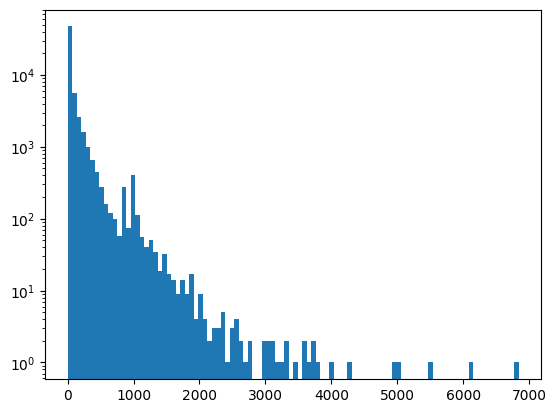

In [9]:
interest_count = [len(interest[1])-1 for interest in user_interests if len(interest[1]) > 1]
plt.hist(interest_count, bins=100, log=True)
plt.show()

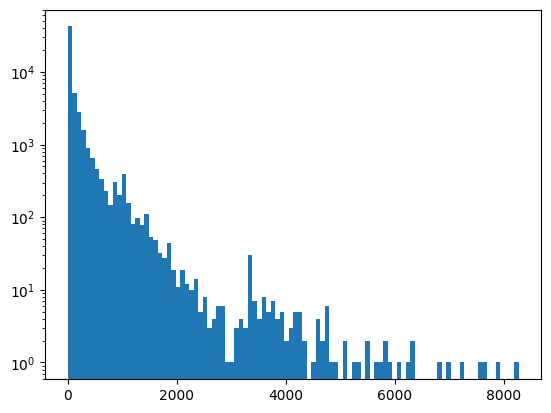

In [8]:
interest_count = [len(interest[1])-1 for interest in user_interests if len(interest[1]) > 1]
plt.hist(interest_count, bins=100, log=True)
plt.show()

In [24]:
npa = list(selected_user_interests[0][1].values())
(len(npa), np.sum([1 for nnn in npa if nnn >0.9]), max(npa), min(npa))

(23, 23, 284.58150099999983, 73.79413900000002)

In [30]:
import sys
# sys.getsizeof(tweets)
sys.getsizeof(explore_tweets)

1032

In [31]:
len(explore_tweets)

63